In [1]:
import pandas as pd
import numpy as np
import requests, json, webbrowser
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import folium
from bs4 import BeautifulSoup

Здесь я пытаюсь работать с данными с музыкального сайта last.fm

API_key = "907e958ff6166f9938a90b99f76499e1"
page = 1
my_format = 'json'

Эта функция выбирает лучшие 50 треков из чарта last.fm, затем сортирует их по количеству прослушиваний и выдает топ-10. Если брать сразу топ-10 из чарта, то выходит слишком много Билли Айлиш и Арианы Гранде. Наверное, остатки пользователей last.fm слушают только это.

In [3]:
def get_top_10_tracks():
    url = 'https://ws.audioscrobbler.com/2.0/?method={}&api_key={}&page={}&limit={}&format={}'
    method = 'chart.getTopTracks'
    limit = 50
    artists = []
    song_names = []
    listeners = []
    playcounts = []
    request_top_tracks = url.format(method, API_key, page, limit, my_format)
    r = requests.get(request_top_tracks).json()
    for item in r['tracks']['track']:
        artists.append(item['artist']['name'])
        song_names.append(item['name'])
        listeners.append(item['listeners'])
        playcounts.append(item['playcount'])
    table = [artists, song_names, listeners, playcounts]
    top_tracks = pd.DataFrame(table).transpose()
    top_tracks[3] = top_tracks[3].astype(int)
    top_tracks = top_tracks.rename(index=str, columns={0: "Artist", 1: "Song", 2: "Listeners", 3: "Play Counts"})
    top_tracks = top_tracks.sort_values(by = ["Play Counts"], ascending = False)
    top_tracks = top_tracks.reset_index().shift()[1:]
    top_tracks["Play Counts"] = top_tracks["Play Counts"].astype(int)
    top_tracks = top_tracks.drop(["index"], axis = 1)
    return top_tracks[0:10]

In [4]:
get_top_10_tracks()

,Artist,Song,Listeners,Play Counts
1,The Killers,Mr. Brightside,1981103,18095120
2,Nirvana,Smells Like Teen Spirit,2066060,16068018
3,Nirvana,Come as You Are,1821802,13441300
4,Arctic Monkeys,Do I Wanna Know?,903873,12388577
5,Toto,Africa,927485,6212673
6,Ariana Grande,No Tears Left To Cry,225523,5678990
7,Ariana Grande,"Thank U, Next",227627,5095752
8,Tame Impala,The Less I Know the Better,422950,4686587
9,Ariana Grande,7 rings,186312,4188218
10,Kendrick Lamar,HUMBLE.,363161,3989958


И как этот топ-10 выглядит на диаграмме. Количество прослушиваний в миллионах.

In [23]:
title = fm.FontProperties(family='Impact', size=20)
labels = fm.FontProperties(family='Times New Roman', size=16)
def draw_top_10_tracks():
    data = get_top_10_tracks()
    artist_song = data['Artist'] + ' - ' + data['Song']
    new_data = pd.DataFrame()
    new_data = new_data.reindex(artist_song)
    play_counts = list(data["Play Counts"] / 1000000)
    new_data["Play Counts"] = play_counts
    ax = new_data.plot.barh(figsize=[10, 10], width=0.8, color='burlywood')
    ax.xaxis.grid(True)
    ax.set_title('Last FM Chart Most Played Songs', fontproperties=title)
    plt.show()

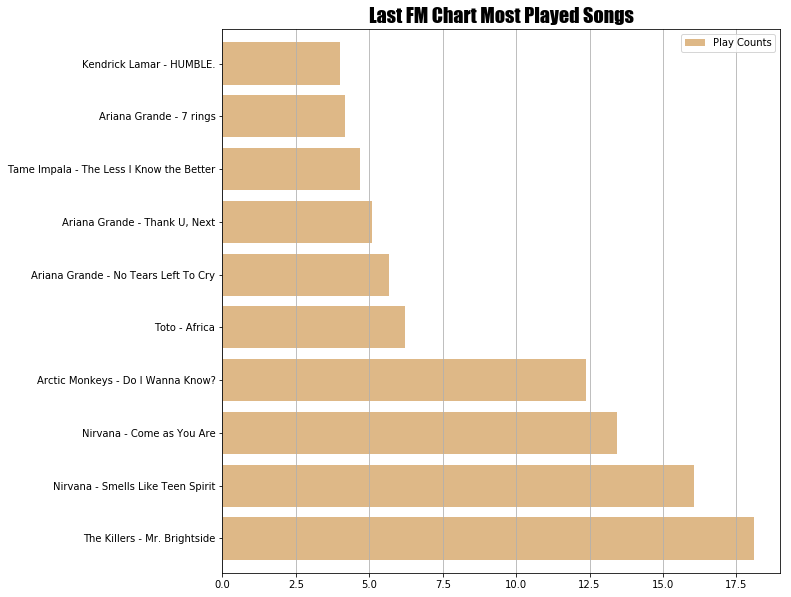

In [24]:
draw_top_10_tracks()

Теперь если вам нравится какая-то песня и хочется найти похожие на нее. В аргументах функции нужно указать исполнителя и название, регистр не имеет значение. На выходе будет топ-10 похожих песен (last.fm как-то высчитывает коэффициент похожести, но методика для меня загадка).

In [6]:
def get_top_similar_tracks(artist, track):
    url = 'https://ws.audioscrobbler.com/2.0/?method={}&api_key={}&limit={}&artist={}&track={}&format={}'
    method = 'track.getSimilar'
    limit = 10
    artists = []
    song_names = []
    request_similar_tracks = url.format(method, API_key, limit, artist, track, my_format)
    r = requests.get(request_similar_tracks).json()
    for item in r['similartracks']['track']:
        artists.append(item['artist']['name'])
        song_names.append(item['name'])
    table = [artists, song_names]
    top_tracks = pd.DataFrame(table).transpose()
    top_tracks = top_tracks.rename(index=str, columns={0: "Artist", 1: "Song"})
    top_tracks = top_tracks.reset_index().shift()[1:]
    top_tracks = top_tracks.drop(["index"], axis = 1)
    return top_tracks

In [7]:
get_top_similar_tracks('Nirvana', 'Marijuana')

,Artist,Song
1,Kurt Cobain,rape me
2,Mudhoney,We Had Love
3,Nirvana,Even In His Youth
4,Nirvana,The Eagle Has Landed
5,Mudhoney,Thirteenth Floor Opening
6,Green River,Ain't Nothing To Do
7,Alice in Chains,Killer Is Me
8,Alice in Chains,Love Hate Love
9,Skin Yard,Throb


Эта функция открывает страницу с песней, где можно ее послушать с:
Я честно пыталась открывать через более используемые сервисы, но пока не получилось.

In [ ]:
def play_a_song(artist, track):
    url = 'https://ws.audioscrobbler.com/2.0/?method={}&api_key={}&page={}&artist={}&track={}&format={}'
    method = 'track.search'
    request_find_a_song = url.format(method, API_key, page, artist, track, my_format)
    r = requests.get(request_find_a_song).json()
    if r['results']['trackmatches']['track'] == []:
        print('Could not find such a song')
    else:
        for item in r['results']['trackmatches']['track']:
            true_artist = item['artist']
            true_song = item['name']
            break
        webbrowser.open_new_tab('http://www.last.fm/music/' + true_artist + '/_/' + true_song)

In [ ]:
play_a_song('Nirvana', 'Marijuana')

Эта функция находит топ-100 исполнителей по тегу. Тегом может быть жанр ('grunge', 'rock', 'pop'), десятилетие ('80s','90s'), характеристики исполнителя ('female vocalists') или национальная принадлежность ('russian', 'polish').

In [9]:
def get_artists_by_tag(tag):
    url = 'https://ws.audioscrobbler.com/2.0/?method={}&api_key={}&limit={}&page={}&tag={}&format={}'
    method = 'tag.getTopArtists'
    limit = 100
    request_find_by_tag = url.format(method, API_key, limit, page, tag, my_format)
    r = requests.get(request_find_by_tag).json()
    artists = []
    for item in r['topartists']['artist']:
        artists.append(item['name'])
    return artists

In [10]:
get_artists_by_tag('rock')

['Coldplay',
 'Linkin Park',
 'Red Hot Chili Peppers',
 'David Bowie',
 'Foo Fighters',
 'Paramore',
 'Kings of Leon',
 'U2',
 'Maroon 5',
 'The White Stripes',
 'My Chemical Romance',
 'Panic! at the Disco',
 'Weezer',
 'Incubus',
 'Evanescence',
 'R.E.M.',
 'Rage Against the Machine',
 'Bruce Springsteen',
 'Nickelback',
 'Papa Roach',
 'Aerosmith',
 'OneRepublic',
 'Bon Jovi',
 'Jimmy Eat World',
 'The Velvet Underground',
 'The Cranberries',
 '3 Doors Down',
 'Audioslave',
 'Tenacious D',
 'Garbage',
 'The Police',
 'Seether',
 'The All-American Rejects',
 'Simple Plan',
 'Dave Matthews Band',
 'No Doubt',
 'Sting',
 'Shinedown',
 'The Pretty Reckless',
 'Black Rebel Motorcycle Club',
 'Lostprophets',
 'Anberlin',
 'Goo Goo Dolls',
 'Manic Street Preachers',
 'Lifehouse',
 'Stereophonics',
 'Counting Crows',
 'Coma',
 'Bloodhound Gang',
 'Alter Bridge',
 'Wolfmother',
 'Lou Reed',
 'Train',
 'The Raconteurs',
 'Lenny Kravitz',
 'Guano Apes',
 'Staind',
 'Bryan Adams',
 'Santana',
 